# 3 layer LSTM Encoder Decoder, dropout. 120 day input, 10 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Conv1D, Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/lstm4.66'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
num_skew_end = 15
data = df.values[:-num_skew_end]

In [3]:
num_input = 120
num_out = 10
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (585, 120, 25)
train_y shape (585, 10, 1)
dev_X shape (69, 120, 25)
dev_y shape (69, 10, 1)
test_X shape (35, 120, 25)
test_y shape (35, 10, 1)
train_y_acc shape (585, 10, 1)
dev_y_acc shape (69, 10, 1)
test_y_acc shape (35, 10, 1)


In [4]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0005
decay = 1e-6
dropout_rate = 0.4
epochs = 1000
batch_size = 32

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=input_shape))
model.add(CuDNNLSTM(200))
model.add(RepeatVector(num_out))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mae", optimizer=opt)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 111, 64)           16064     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 200)               212800    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 200)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 10, 200)           321600    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 100)           20100     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 1)             101       
Total params: 570,665
Trainable params: 570,665
Non-trainable params: 

In [5]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 1000 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 585 samples, validate on 69 samples
Epoch 1/1000
585/585 [==============================] - 2s 4ms/step - loss: 0.1175 - val_loss: 0.0765
Epoch 2/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0585 - val_loss: 0.0656
Epoch 3/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0430 - val_loss: 0.0463
Epoch 4/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0351 - val_loss: 0.0467
Epoch 5/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0347 - val_loss: 0.0462
Epoch 6/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0362 - val_loss: 0.0393
Epoch 7/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0295 - val_loss: 0.0419
Epoch 8/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0312 - val_loss: 0.0346
Epoch 9/1000
585/585 [=========

Epoch 77/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 0.0153
Epoch 78/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0124 - val_loss: 0.0157
Epoch 79/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 0.0156
Epoch 80/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0121 - val_loss: 0.0140
Epoch 81/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0143
Epoch 82/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0127 - val_loss: 0.0160
Epoch 83/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0133
Epoch 84/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0112 - val_loss: 0.0127
Epoch 85/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0126
Epoch 86/1000
585/585 [==============================] - 1s 1ms/step - lo

Epoch 156/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0094 - val_loss: 0.0107
Epoch 157/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0094 - val_loss: 0.0117
Epoch 158/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0094 - val_loss: 0.0111
Epoch 159/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0092 - val_loss: 0.0113
Epoch 160/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0101 - val_loss: 0.0141
Epoch 161/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0115
Epoch 162/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0101 - val_loss: 0.0152
Epoch 163/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0104 - val_loss: 0.0116
Epoch 164/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0098 - val_loss: 0.0127
Epoch 165/1000
585/585 [==============================] - 1s 1ms

Epoch 235/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0077 - val_loss: 0.0097
Epoch 236/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0080 - val_loss: 0.0099
Epoch 237/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0081 - val_loss: 0.0100
Epoch 238/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0081 - val_loss: 0.0105
Epoch 239/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0081 - val_loss: 0.0102
Epoch 240/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0079 - val_loss: 0.0099
Epoch 241/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0076 - val_loss: 0.0097
Epoch 242/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0080 - val_loss: 0.0114
Epoch 243/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0088 - val_loss: 0.0101
Epoch 244/1000
585/585 [==============================] - 1s 1ms

Epoch 314/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0080 - val_loss: 0.0093
Epoch 315/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0078 - val_loss: 0.0130
Epoch 316/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0103 - val_loss: 0.0108
Epoch 317/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0089 - val_loss: 0.0111
Epoch 318/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0081 - val_loss: 0.0101
Epoch 319/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0084 - val_loss: 0.0103
Epoch 320/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0079 - val_loss: 0.0092
Epoch 321/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0096
Epoch 322/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0077 - val_loss: 0.0096
Epoch 323/1000
585/585 [==============================] - 1s 1ms

Epoch 393/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0080 - val_loss: 0.0093
Epoch 394/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0074 - val_loss: 0.0106
Epoch 395/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0076 - val_loss: 0.0088
Epoch 396/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0080 - val_loss: 0.0101
Epoch 397/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0093
Epoch 398/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0072 - val_loss: 0.0091
Epoch 399/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0079 - val_loss: 0.0102
Epoch 400/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0076 - val_loss: 0.0106
Epoch 401/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0071 - val_loss: 0.0092
Epoch 402/1000
585/585 [==============================] - 1s 1ms

Epoch 472/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0077 - val_loss: 0.0082
Epoch 473/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0069 - val_loss: 0.0091
Epoch 474/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0081
Epoch 475/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0069 - val_loss: 0.0092
Epoch 476/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0104
Epoch 477/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0084 - val_loss: 0.0098
Epoch 478/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 479/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0086
Epoch 480/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0073 - val_loss: 0.0094
Epoch 481/1000
585/585 [==============================] - 1s 1ms

Epoch 551/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0069 - val_loss: 0.0109
Epoch 552/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0089
Epoch 553/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0084
Epoch 554/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0087
Epoch 555/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0093
Epoch 556/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0061 - val_loss: 0.0079
Epoch 557/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0071 - val_loss: 0.0092
Epoch 558/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0093
Epoch 559/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0092
Epoch 560/1000
585/585 [==============================] - 1s 1ms

Epoch 630/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0080
Epoch 631/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0055 - val_loss: 0.0076
Epoch 632/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0057 - val_loss: 0.0080
Epoch 633/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0055 - val_loss: 0.0079
Epoch 634/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0057 - val_loss: 0.0086
Epoch 635/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0087
Epoch 636/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0085
Epoch 637/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0086
Epoch 638/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0088
Epoch 639/1000
585/585 [==============================] - 1s 1ms

Epoch 709/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0054 - val_loss: 0.0083
Epoch 710/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0083
Epoch 711/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0084
Epoch 712/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0057 - val_loss: 0.0082
Epoch 713/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0055 - val_loss: 0.0081
Epoch 714/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0053 - val_loss: 0.0084
Epoch 715/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0053 - val_loss: 0.0080
Epoch 716/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0049 - val_loss: 0.0080
Epoch 717/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0047 - val_loss: 0.0079
Epoch 718/1000
585/585 [==============================] - 1s 1ms

Epoch 788/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0054 - val_loss: 0.0081
Epoch 789/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0050 - val_loss: 0.0078
Epoch 790/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0050 - val_loss: 0.0087
Epoch 791/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0089
Epoch 792/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0078
Epoch 793/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0049 - val_loss: 0.0079
Epoch 794/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0081
Epoch 795/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0084
Epoch 796/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0057 - val_loss: 0.0086
Epoch 797/1000
585/585 [==============================] - 1s 1ms

Epoch 867/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0080
Epoch 868/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0079
Epoch 869/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0050 - val_loss: 0.0088
Epoch 870/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0084
Epoch 871/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0047 - val_loss: 0.0079
Epoch 872/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0048 - val_loss: 0.0080
Epoch 873/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0049 - val_loss: 0.0088
Epoch 874/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0080
Epoch 875/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0049 - val_loss: 0.0080
Epoch 876/1000
585/585 [==============================] - 1s 1ms

Epoch 946/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0085
Epoch 947/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0047 - val_loss: 0.0080
Epoch 948/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0078
Epoch 949/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0081
Epoch 950/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0044 - val_loss: 0.0080
Epoch 951/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0084
Epoch 952/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0044 - val_loss: 0.0076
Epoch 953/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0041 - val_loss: 0.0079
Epoch 954/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0076
Epoch 955/1000
585/585 [==============================] - 1s 1ms

In [6]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

print("MAE Train:", mean_absolute_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MAE Dev:", mean_absolute_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MAE Test:", mean_absolute_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.0001135663036187695
MSE Dev: 0.0002676285456348129
MSE Test: 0.00020769950217201983
MAE Train: 0.007332346964776255
MAE Dev: 0.009801160533996399
MAE Test: 0.012011544283213108


In [7]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

l = go.Scatter(y=history.history['loss'], name='train')
v = go.Scatter(y=history.history['val_loss'], name='dev')

data = [v,l]
py.iplot(data, filename='line-mode')

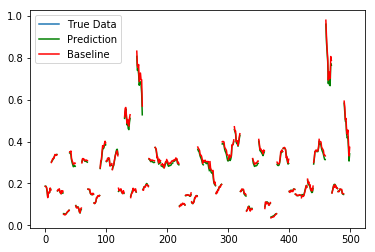

In [8]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_train.tolist()[:50], [], num_out, baseline_data=true_train.tolist()[:50])

# predicted_train = model.predict(train_X).squeeze()
# predicted_train = predicted_train[:, 0].reshape(-1,1)
# true_train = train_y[:, 0].reshape(-1,1)
# utils.plot_results(predicted_train[:50], true_train[:50])

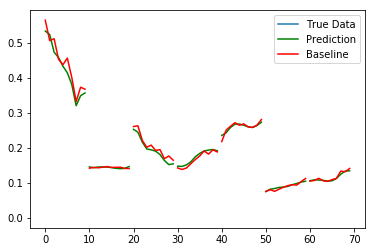

VAR MAE Dev: 0.005448766939753039
LSTM MAE Dev: 0.0001239316311832554
VAR MSE Dev: 0.005448766939753039
LSTM MSE Dev: 0.0001239316311832554


In [9]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_dev.tolist(), [0], num_out, baseline_data=true_dev.tolist())

true_dev = true_dev.reshape(-1,1)

var_preds_dev = utils.var_predict(dev_X[:, :, 0:5], num_out)
var_preds_dev = var_preds_dev[::num_out]

print("VAR MAE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MAE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

print("VAR MSE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

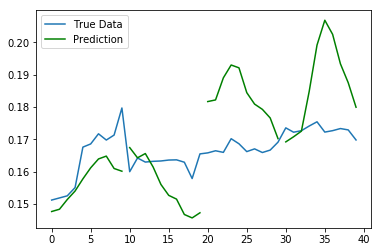

In [10]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[::num_out].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

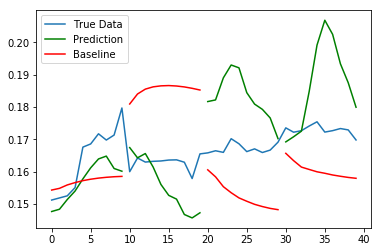

VAR MAE Test: 0.014679061944746335
LSTM MAE Test: 0.01160379841178017
VAR MSE Test: 0.0002570678369552715
LSTM MSE Test: 0.00020652015231298885


In [11]:
var_preds = utils.var_predict(test_X[:, :, 0:5], num_out)
var_preds = var_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=var_preds.tolist())

print("VAR MAE Test:", mean_absolute_error(var_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("VAR MSE Test:", mean_squared_error(var_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



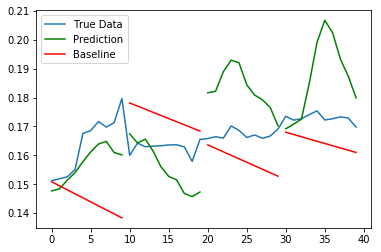

ARIMA MAE Test: 0.011817364924727753
LSTM MAE Test: 0.01160379841178017
ARIMA MSE Test: 0.00021404134489758325
LSTM MSE Test: 0.00020652015231298885


In [12]:
arima_preds = utils.arima_predict(test_X[:, :, 0], num_out)
arima_preds = arima_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=arima_preds.tolist())

print("ARIMA MAE Test:", mean_absolute_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("ARIMA MSE Test:", mean_squared_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

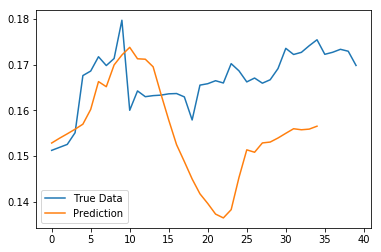

In [36]:
predicted_test_single = model.predict(test_X).squeeze()
predicted_test_single = predicted_test_single[:, 0]
utils.plot_results(predicted_test_single, true_test)